# Gradient Bandit Algorithm Study

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.special import softmax

## Environment Model

In [ ]:
# Input: Action
# Output: Reward

class Student():
    def __init__(self):
        pass

    def get_reward(self, action):
        if action == 0:
            score = truncnorm(a=(0-40)/40, b=(100-40)/40, loc=40, scale=40).rvs(size=1).astype(int)
        elif action == 1:
            score = truncnorm(a=(0-60)/10, b=(100-60)/10, loc=60, scale=10).rvs(size=1).astype(int)
        else:
            score = truncnorm(a=(0-50)/20, b=(100-50)/20, loc=50, scale=20).rvs(size=1).astype(int)

        return score

class Environment():
    def __init__(self, student):
        self.student = student

    def step(self, action):
        reward = self.student.get_reward(action)
        return reward

## Agent Model

In [ ]:
class Gradient_Bandit_Agent():
  def __init__(self, learning_rate, num_actions, probabilities_update_interval):

    # how fast the agent will learn
    self.learning_rate = learning_rate

    # we have 3 actions(programs) in the case of this problem
    self.num_actions = num_actions

    # how often do we update the probabilities of choosing each action
    # (in this case we update the probabilities after we update the preference of
    # every 100 students)
    self.probabilities_update_interval = probabilities_update_interval

    # initialize preferences with the same value as each other
    self.preferences = np.full(num_actions, 1.5e4)

    # history of what has been going on
    self.reward_history = []
    self.action_history = []

    # calculate the probability of choosing each action based on the preference
    self._calc_action_probability()

    # intialize mean reward and time step values
    self.reward_mean = 0
    self.time_step = 0


  def _calc_action_probability(self):
    self.action_probabilities = softmax(self.preferences)


  def select_action(self):
    return np.random.choice(self.num_actions, p=self.action_probabilities)


  def update_preferences(self, action, reward):

    # add actions and rewards to the history
    self.reward_history.append(reward)
    self.action_history.append(action)

    # one time step has passed so update the time step and the mean reward
    self.time_step += 1
    self.reward_mean += (1 / self.time_step) * (reward - self.reward_mean)

    # now update the preferences
    for a in range(self.num_actions):
        if a == action:
            self.preferences[a] += self.learning_rate * (reward - self.reward_mean) * (1 - self.action_probabilities[a])
        else:
            self.preferences[a] -= self.learning_rate * (reward - self.reward_mean) * self.action_probabilities[a]

    # update the probabilities after updating 100 preferences of the students
    # (AKA. at the end of each week)
    if self.time_step % self.probabilities_update_interval == 0:
      self._calc_action_probability()


## Agent Train

A single Run of the training

In [ ]:
def run(env, agent, num_steps):

  for step in range(0, num_steps):

    action = agent.select_action()
    reward = env.step(action)

    agent.update_preferences(action, reward)

  rewards = agent.reward_history

  return np.array(rewards).squeeze()

Running the Model

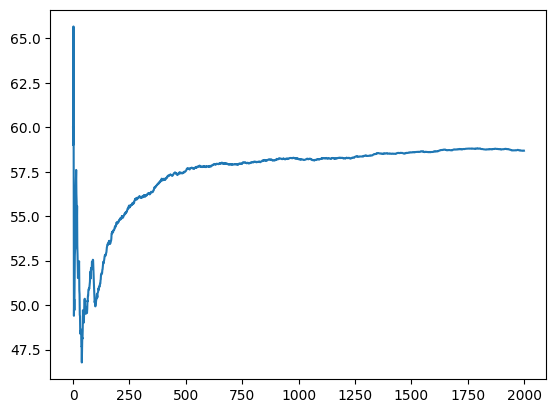

In [ ]:
STUDENTS = 100
STEPS = 20*STUDENTS
ACTIONS = 3
LEARNING_RATES = 0.1

env = Environment(Student())
agent = Gradient_Bandit_Agent(LEARNING_RATES, ACTIONS, STUDENTS)
rewards = run(env, agent, STEPS)
mean_rewards = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)

plt.plot(mean_rewards)